In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import SALib
from SALib.plotting import bar

# read Sobol' sensitivity indices as dataframe
from settings import SOBOL_DATA_DIR, FIGURE_DIR
from utils.Sobol_G_setting import set_sobol_g_func

## Plot Sobol' SA with dummy parameter included

<Figure size 576x432 with 0 Axes>

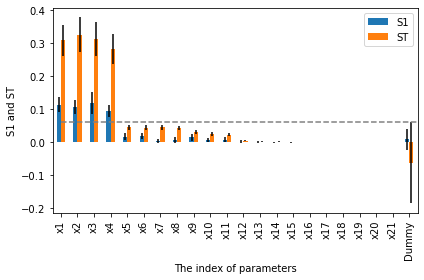

In [4]:
df = pd.read_csv(f'../output/sobol/Sobol_indices.csv', index_col = 'Unnamed: 0')
a, x, x_bounds, x_names, len_params, problem = set_sobol_g_func()

df_plot = pd.DataFrame()
df_plot.loc[:, 'S1'] = df[df.Type == 'S1']['result_5000'].values
df_plot.loc[:, 'S1_conf'] = df[df.Type == 'S1_conf']['result_5000'].values
df_plot.loc[:, 'ST'] = df[df.Type == 'ST']['result_5000'].values
df_plot.loc[:, 'ST_conf'] = df[df.Type == 'ST_conf']['result_5000'].values
threshold = df_plot.loc[21, 'ST'] + df_plot.loc[21, 'ST_conf']

fig = plt.figure(figsize = (8, 6))
ax = bar.plot(df_plot)
ax.set_xticklabels([* problem['names'], 'Dummy'])
ax.set_xlabel('The index of parameters')
ax.set_ylabel('S1 and ST')
plt.tight_layout()
plt.hlines(threshold, xmin=0, xmax=22, colors = 'grey', linestyle='--')
# plt.savefig(f'../output/sobol/Sobol_dummy.png', format = 'png', dpi = 300)

## Plot the adaptive evaluation

In [10]:
from settings import *
df = {}
fpath = '../output/morris/adaptive/'
for fn in METRIC_NAME:
    df[fn] = pd.read_csv(f'{fpath}{fn}.csv', index_col = 'Unnamed: 0').T.iloc[5:]
    # df = df.iloc[5:]

AttributeError: 'dict' object has no attribute 'iloc'

In [11]:
metrics = [fn for fn in METRIC_NAME if not '_' in fn ]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
for ii in range(len(metrics)):
    metric = metrics[ii]
    ax = df[metric].plot(kind='line', marker='o', linewidth=1, style='--', ms=3, ax = axes[ii])
    cols = df[metric].columns
    for col in cols:
        ax.fill_between(df[metric].index, df[f'{metric}_lower'].loc[:, col], df[f'{metric}_upper'].loc[:, col], alpha = 0.5)
    if ii == 0:
        ax.hlines(0.06, df[metric].index[0], df[metric].index[-1])
    else:
        ax.hlines(1.06, df[metric].index[0], df[metric].index[-1])
        ax.hlines(0.94, df[metric].index[0], df[metric].index[-1])
    ax.set_xlabel('Sample size');
    ax.set_ylabel(metric, fontsize = 10);

KeyError: 'mae_lower'

In [44]:
df['var'].head(50)

,0,1,2,3,4
sample_10,0.0,2.440081,1.233551,1.133583,0.979173
sample_20,0.0,4.112027,1.059641,0.997631,0.976676
sample_30,0.0,3.937403,1.053031,0.983012,0.977932
sample_40,0.0,1.369099,0.974243,1.057576,1.006846
sample_50,0.0,0.919736,0.948653,1.048948,1.001747
sample_60,0.0,0.907086,0.956243,1.054050,1.001812
sample_70,0.0,0.664602,1.032729,1.081487,1.000495
sample_80,0.0,0.658108,1.043916,1.083275,1.001501
sample_90,0.0,0.656559,1.016947,1.069698,0.998852
sample_100,0.0,0.660260,1.028116,1.073157,1.000307
